# English football stadiums

#### Import Python tools

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import requests
import json
from bs4 import BeautifulSoup

# from dms2dec.dms_convert import dms2dec
# import contextily as cx
import re

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.set_option("display.max_colwidth", None)

In [4]:
today = pd.Timestamp("today").strftime("%m/%d/%Y")

---

## Get data

#### Read table showing past winners

In [5]:
src = (
    pd.read_html("https://en.wikipedia.org/wiki/List_of_Premier_League_stadiums")[0]
).fillna("")

In [6]:
src.columns = (
    src.columns.str.lower()
    .str.replace(" ", "_")
    .str.replace("#_", "")
    .str.replace("_(m)", "", regex=False)
)

In [7]:
src["coordinates"] = src["coordinates"].str.replace(
    ".mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}",
    "",
    regex=False,
)

In [8]:
src = src.drop(["image", "ref.", "pitch_length", "pitch_width"], axis=1).copy()

In [9]:
src["opened"] = src["opened"].astype(str)
src["closed"] = src["closed"].astype(str).str.replace(".0", "", regex=False)

In [10]:
src[["coordinates_dms", "coordinates_other"]] = src["coordinates"].str.split(
    " / ", expand=True
)

In [11]:
src["stadium"] = (
    src["stadium"]
    .str.replace(" Formerly Reebok Stadium and Macron Stadium", "", regex=False)
    .str.replace(" Formerly Britannia Stadium", "", regex=False)
    .str.replace(" (also known as Upton Park)", "", regex=False)
    .str.replace(" Formerly Walkers Stadium", "", regex=False)
    .str.replace(" Formerly JJB Stadium", "", regex=False)
    .str.replace(" Formerly Olympic Stadium", "", regex=False)
    .str.replace(" Formerly KCOM Stadium", "", regex=False)
    .str.replace(" Formerly Liberty Stadium", "", regex=False)
)

In [12]:
df = src[(src["closed"] == "") & (src["club"] != "—[nb 1]")].copy()

In [13]:
df["coordinates_other"] = df["coordinates_other"].str.replace("﻿", "")

pattern = re.compile(r"([0-9.]+)°([NS]) ([0-9.]+)°([EW])")


def convert_coordinates(row):
    lat, lat_dir, lon, lon_dir = pattern.search(row).groups()
    lat = float(lat)
    lon = float(lon)
    lat = lat if lat_dir == "N" else -lat
    lon = lon if lon_dir == "E" else -lon
    return f"{lat},{lon}"


df["coordinates_new"] = df["coordinates_other"].apply(convert_coordinates)

In [14]:
df["opened"] = (
    df["opened"]
    .str.replace("[16]", "", regex=False)
    .str.replace("[17]", "", regex=False)
    .str.replace("[27]", "", regex=False)
)

In [15]:
df[["lat", "lon"]] = df["coordinates_new"].str.split(",", expand=True)

In [16]:
df = df.drop(
    ["closed", "coordinates_dms", "coordinates_other", "coordinates"], axis=1
).copy()

---

## Geography

In [24]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat)).set_crs(
    epsg=4326
)

In [34]:
gdf.head()

,stadium,club,location,opened,capacity,coordinates_new,lat,lon,geometry
0,Anfield,Liverpool,Liverpool,1884,61276,"53.43083,-2.96083",53.43083,-2.96083,POINT (-2.96083 53.43083)
4,bet365 Stadium,Stoke City,Stoke-on-Trent,1997,30089,"52.98833,-2.17556",52.98833,-2.17556,POINT (-2.17556 52.98833)
5,Bloomfield Road,Blackpool,Blackpool,1899,16220,"53.80472,-3.04806",53.80472,-3.04806,POINT (-3.04806 53.80472)
7,Boundary Park,Oldham Athletic,Oldham,1904,13559,"53.55528,-2.12861",53.55528,-2.12861,POINT (-2.12861 53.55528)
8,Bramall Lane,Sheffield United,Sheffield,1855,32050,"53.37028,-1.47083",53.37028,-1.47083,POINT (-1.47083 53.37028)


<AxesSubplot: >

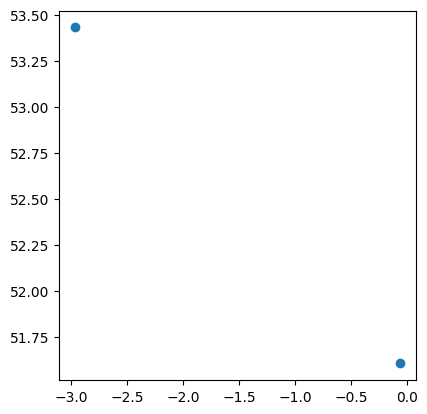

In [32]:
gdf.query('stadium == "Anfield" or stadium == "Tottenham Hotspur Stadium"').plot()

In [26]:
df.to_csv("data/processed/english_football_stadiums.csv", index=False)
gdf.to_file("data/processed/english_football_stadiums_geo.geojson", driver="GeoJSON")
gdf.query('location == "London"').to_file(
    "data/processed/english_football_stadiums_geo_london.geojson", driver="GeoJSON"
)